In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from sklearn.model_selection import KFold

In [2]:
fogData = xr.open_dataset('../../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))
yAll=yAll/25.0

In [3]:
#Surface data
t2mData = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')
# Read Orography
OroData = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')
z500Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')

In [4]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [5]:
# Calculate wind speed 
ws = ((v10Data.v10.values**2)+(u10Data.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [6]:
#Calculate inv
inv=t2mData.t2m.values-tuv850Data.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [7]:
#u shear calculation
ushear=(tuv850Data.u.values-u10Data.u10.values)/(z850Data.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [8]:
# AO Input
AOData1 = xr.open_dataset('../../../../Data/AO_EU/AO_Calculated.nc')
print(AOData1)

Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(AOData1.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), AOData1.AO[t].values)
AOData=xr.Dataset({'AO': (('time','latitude','longitude'), Darray)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})    

<xarray.Dataset>
Dimensions:  (time: 3772)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
Data variables:
    AO       (time) float32 ...


In [9]:
#EU Input
EUData1 = xr.open_dataset('../../../../Data/AO_EU/EU_NovDecJan.nc')
Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(EUData1.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), EUData1.EUVal[t].values)
EUData=xr.Dataset({'EU': (('time','latitude','longitude'), Darray)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})    

In [10]:
t2m=t2mData.t2m.shift(time=1)
ws=ws_ds.ws.shift(time=1)
rh=rh_ds.rh.shift(time=1)
inv=inv_ds.inv.shift(time=1)
w=w700Data.w.shift(time=1)
ushear=ushear_ds.ushear.shift(time=1)
ao=AOData.AO.shift(time=1)
eu=EUData.EU.shift(time=1)

In [11]:
t2mTsAll=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wsTsAll=ws[((ws.time.dt.month>11) | (ws.time.dt.month<2)) & (ws.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTsAll=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
invTsAll=inv[((inv.time.dt.month>11) | (inv.time.dt.month<2)) & (inv.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
ushearTsAll=ushear[((ushear.time.dt.month>11) | (ushear.time.dt.month<2)) & (ushear.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
aoTsAll=ao[((ao.time.dt.month>11) | (ao.time.dt.month<2)) & (ao.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
euTsAll=eu[((eu.time.dt.month>11) | (eu.time.dt.month<2)) & (eu.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wTsAll=w[((w.time.dt.month>11) | (w.time.dt.month<2)) & (w.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [12]:
# create mask
oro = OroData.z.sel(latitude=slice(35,0),longitude=slice(50,100))
oro.values = OroData.z.sel(latitude=slice(35,0),longitude=slice(50,100)).values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values

In [13]:
t2mTsAll.values=t2mTsAll.values*mask
wsTsAll.values=wsTsAll.values*mask
rhTsAll.values=rhTsAll.values*mask
invTsAll.values=invTsAll.values*mask
ushearTsAll.values=ushearTsAll.values*mask
wTsAll.values=wTsAll.values*mask
aoTsAll.values=aoTsAll.values*mask
euTsAll.values=euTsAll.values*mask

In [14]:
t2mTsAll.values=xr.where(np.isnan(t2mTsAll.values),  0.000000000001,t2mTsAll.values)
wsTsAll.values=xr.where(np.isnan(wsTsAll.values),  0.000000000001,wsTsAll.values)
rhTsAll.values=xr.where(np.isnan(rhTsAll.values),  0.000000000001,rhTsAll.values)
invTsAll.values=xr.where(np.isnan(invTsAll.values),  0.000000000001,invTsAll.values)
ushearTsAll.values=xr.where(np.isnan(ushearTsAll.values),  0.000000000001,ushearTsAll.values)
wTsAll.values=xr.where(np.isnan(wTsAll.values),  0.000000000001,wTsAll.values)
aoTsAll.values=xr.where(np.isnan(aoTsAll.values),  0.000000000001,aoTsAll.values)
euTsAll.values=xr.where(np.isnan(euTsAll.values),  0.000000000001,euTsAll.values)

In [15]:
t1=t2mTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTsAll.values=t1.unstack()

t1=wsTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wsTsAll.values=t1.unstack()

t1=rhTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTsAll.values=t1.unstack()

t1=invTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
invTsAll.values=t1.unstack()

t1=ushearTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
ushearTsAll.values=t1.unstack()

t1=aoTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
aoTsAll.values=t1.unstack()

t1=euTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
euTsAll.values=t1.unstack()

t1=wTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wTsAll.values=t1.unstack()


In [16]:
t2m_train,t2m_test,ws_train,ws_test,rh_train,rh_test,inv_train,inv_test, w_train, w_test,ushear_train, ushear_test,ao_train,ao_test,eu_train,eu_test,y_train,y_test= train_test_split( t2mTsAll,wsTsAll,rhTsAll,invTsAll, wTsAll,ushearTsAll,aoTsAll,euTsAll,yAll,test_size=0.20, random_state=0)

In [17]:
t2mtrain=t2m_train.values
t2mtrain=t2mtrain[:,:,:,None]
t2mtrain.shape


wstrain=ws_train.values
wstrain=wstrain[:,:,:,None]
wstrain.shape

rhtrain=rh_train.values
rhtrain=rhtrain[:,:,:,None]
rhtrain.shape


invtrain=inv_train.values
invtrain=invtrain[:,:,:,None]
invtrain.shape

wtrain=w_train.values
wtrain=wtrain[:,:,:,None]
wtrain.shape

usheartrain=ushear_train.values
usheartrain=usheartrain[:,:,:,None]
usheartrain.shape

aotrain=ao_train.values
aotrain=aotrain[:,:,:,None]
aotrain.shape

eutrain=eu_train.values
eutrain=eutrain[:,:,:,None]
eutrain.shape

(1934, 18, 26, 1)

In [18]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape


wstest=ws_test.values
wstest=wstest[:,:,:,None]
wstest.shape

rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape


invtest=inv_test.values
invtest=invtest[:,:,:,None]
invtest.shape

wtest=w_test.values
wtest=wtest[:,:,:,None]
wtest.shape

usheartest=ushear_test.values
usheartest=usheartest[:,:,:,None]
usheartest.shape

aotest=ao_test.values
aotest=aotest[:,:,:,None]
aotest.shape

eutest=eu_test.values
eutest=eutest[:,:,:,None]
eutest.shape

(484, 18, 26, 1)

In [19]:
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(484, 1)

In [20]:
#X_test=np.array([t2mtest,rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
X_test=np.array([rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
X_test.shape

#X_train=np.array([t2mtrain,rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
X_train=np.array([rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
X_train.shape

(7, 1934, 18, 26, 1)

In [21]:
X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

(484, 7, 18, 26, 1)

# Kfold CV

In [23]:
#LeNet-5 Architecture

Epoch 1/20
55/55 [==============================] - 9s 122ms/step - loss: 0.2883 - mse: 0.1875 - val_loss: 0.1528 - val_mse: 0.0424
Epoch 2/20
55/55 [==============================] - 6s 115ms/step - loss: 0.1674 - mse: 0.0439 - val_loss: 0.1361 - val_mse: 0.0287
Epoch 3/20
55/55 [==============================] - 6s 115ms/step - loss: 0.1314 - mse: 0.0282 - val_loss: 0.1066 - val_mse: 0.0184
Epoch 4/20
55/55 [==============================] - 6s 114ms/step - loss: 0.1092 - mse: 0.0199 - val_loss: 0.1089 - val_mse: 0.0206
Epoch 5/20
55/55 [==============================] - 6s 113ms/step - loss: 0.1008 - mse: 0.0182 - val_loss: 0.1029 - val_mse: 0.0185
Epoch 6/20
55/55 [==============================] - 6s 116ms/step - loss: 0.0983 - mse: 0.0163 - val_loss: 0.0972 - val_mse: 0.0162
Epoch 7/20
55/55 [==============================] - 6s 114ms/step - loss: 0.0878 - mse: 0.0135 - val_loss: 0.0943 - val_mse: 0.0165
Epoch 8/20
55/55 [==============================] - 6s 115ms/step - loss: 0.

Epoch 5/20
55/55 [==============================] - 6s 114ms/step - loss: 0.0969 - mse: 0.0165 - val_loss: 0.1034 - val_mse: 0.0179
Epoch 6/20
55/55 [==============================] - 6s 117ms/step - loss: 0.0897 - mse: 0.0143 - val_loss: 0.1049 - val_mse: 0.0159
Epoch 7/20
55/55 [==============================] - 6s 114ms/step - loss: 0.0835 - mse: 0.0122 - val_loss: 0.0961 - val_mse: 0.0141
Epoch 8/20
55/55 [==============================] - 6s 115ms/step - loss: 0.0818 - mse: 0.0119 - val_loss: 0.1039 - val_mse: 0.0163
Epoch 9/20
55/55 [==============================] - 6s 114ms/step - loss: 0.0764 - mse: 0.0101 - val_loss: 0.0943 - val_mse: 0.0139
Epoch 10/20
55/55 [==============================] - 6s 114ms/step - loss: 0.0689 - mse: 0.0087 - val_loss: 0.0969 - val_mse: 0.0139
Epoch 11/20
55/55 [==============================] - 6s 114ms/step - loss: 0.0776 - mse: 0.0104 - val_loss: 0.0947 - val_mse: 0.0147
Epoch 12/20
55/55 [==============================] - 6s 114ms/step - loss:

55/55 [==============================] - 6s 113ms/step - loss: 0.0710 - mse: 0.0094 - val_loss: 0.0967 - val_mse: 0.0148
Epoch 14/20
55/55 [==============================] - 6s 112ms/step - loss: 0.0668 - mse: 0.0081 - val_loss: 0.0942 - val_mse: 0.0152
Epoch 15/20
55/55 [==============================] - 6s 115ms/step - loss: 0.0615 - mse: 0.0072 - val_loss: 0.0929 - val_mse: 0.0140
Epoch 16/20
55/55 [==============================] - 6s 113ms/step - loss: 0.0620 - mse: 0.0069 - val_loss: 0.0896 - val_mse: 0.0130
Epoch 17/20
55/55 [==============================] - 6s 113ms/step - loss: 0.0584 - mse: 0.0067 - val_loss: 0.0963 - val_mse: 0.0150
Epoch 18/20
55/55 [==============================] - 6s 114ms/step - loss: 0.0568 - mse: 0.0063 - val_loss: 0.0939 - val_mse: 0.0140
Epoch 19/20
55/55 [==============================] - 6s 115ms/step - loss: 0.0529 - mse: 0.0052 - val_loss: 0.0943 - val_mse: 0.0140
Epoch 20/20
55/55 [==============================] - 6s 114ms/step - loss: 0.0456

mse: 1.34%
Epoch 1/20
55/55 [==============================] - 7s 119ms/step - loss: 0.2045 - mse: 0.0718 - val_loss: 0.1581 - val_mse: 0.0364
Epoch 2/20
55/55 [==============================] - 6s 115ms/step - loss: 0.1565 - mse: 0.0390 - val_loss: 0.1275 - val_mse: 0.0253
Epoch 3/20
55/55 [==============================] - 6s 114ms/step - loss: 0.1281 - mse: 0.0277 - val_loss: 0.1239 - val_mse: 0.0252
Epoch 4/20
55/55 [==============================] - 6s 115ms/step - loss: 0.1094 - mse: 0.0202 - val_loss: 0.1162 - val_mse: 0.0223
Epoch 5/20
55/55 [==============================] - 6s 114ms/step - loss: 0.1040 - mse: 0.0184 - val_loss: 0.1089 - val_mse: 0.0185
Epoch 6/20
55/55 [==============================] - 6s 116ms/step - loss: 0.1005 - mse: 0.0175 - val_loss: 0.1057 - val_mse: 0.0193
Epoch 7/20
55/55 [==============================] - 6s 115ms/step - loss: 0.0836 - mse: 0.0123 - val_loss: 0.1115 - val_mse: 0.0205
Epoch 8/20
55/55 [==============================] - 6s 113ms/step

Epoch 5/20
55/55 [==============================] - 6s 115ms/step - loss: 0.1027 - mse: 0.0182 - val_loss: 0.1175 - val_mse: 0.0197
Epoch 6/20
55/55 [==============================] - 6s 114ms/step - loss: 0.0978 - mse: 0.0159 - val_loss: 0.1083 - val_mse: 0.0188
Epoch 7/20
55/55 [==============================] - 6s 114ms/step - loss: 0.0891 - mse: 0.0139 - val_loss: 0.1113 - val_mse: 0.0182
Epoch 8/20
55/55 [==============================] - 6s 116ms/step - loss: 0.0862 - mse: 0.0130 - val_loss: 0.0963 - val_mse: 0.0157
Epoch 9/20
55/55 [==============================] - 6s 116ms/step - loss: 0.0837 - mse: 0.0122 - val_loss: 0.0999 - val_mse: 0.0159
Epoch 10/20
55/55 [==============================] - 6s 117ms/step - loss: 0.0757 - mse: 0.0100 - val_loss: 0.0966 - val_mse: 0.0148
Epoch 11/20
55/55 [==============================] - 6s 116ms/step - loss: 0.0779 - mse: 0.0107 - val_loss: 0.1088 - val_mse: 0.0179
Epoch 12/20
55/55 [==============================] - 6s 115ms/step - loss:

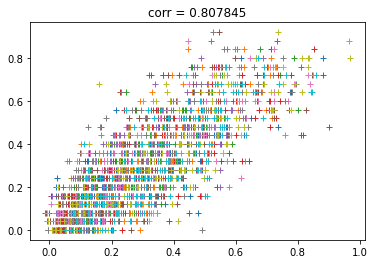

In [29]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []

for train, test in kfold.split(X_train_reshape , y_train):
    cnn1 = Sequential()
    cnn1.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',input_shape=
                    (X_train_reshape[train].shape[1],X_train_reshape[train].shape[2],
                     X_train_reshape[train].shape[3],1)),)
    cnn1.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn1.add(Conv3D(16, kernel_size=5, activation='relu',padding='same'))
    cnn1.add(MaxPooling3D(pool_size=2,padding='same'))

    cnn1.add(Flatten())

    cnn1.add(Dense(120, activation='relu'))
    cnn1.add(Dense(84, activation='relu'))
    cnn1.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn1.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn1.fit(X_train_reshape[train], y_train[train], validation_data=(X_train_reshape[test], 
                                                                                y_train[test]), epochs=20)
    yy_test = cnn1.predict(X_train_reshape[test])
    test_corr = np.corrcoef(yy_test[:,0],y_train[test])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_train[test],'+')
    scores = cnn1.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (cnn1.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("CNN1 LeNet-5")    
print("%.2f%% (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores))) 

     

 # Conv-Pool-Conv-Pool kind of architecture with doubling the number of filters every stage

Epoch 1/20
55/55 [==============================] - 25s 447ms/step - loss: 0.2984 - mse: 0.2233 - val_loss: 0.1516 - val_mse: 0.0393
Epoch 2/20
55/55 [==============================] - 33s 601ms/step - loss: 0.1663 - mse: 0.0434 - val_loss: 0.1121 - val_mse: 0.0218
Epoch 3/20
55/55 [==============================] - 24s 436ms/step - loss: 0.1188 - mse: 0.0225 - val_loss: 0.1035 - val_mse: 0.0171
Epoch 4/20
55/55 [==============================] - 24s 436ms/step - loss: 0.0972 - mse: 0.0157 - val_loss: 0.0898 - val_mse: 0.0148
Epoch 5/20
55/55 [==============================] - 24s 439ms/step - loss: 0.0962 - mse: 0.0151 - val_loss: 0.0920 - val_mse: 0.0160
Epoch 6/20
55/55 [==============================] - 24s 434ms/step - loss: 0.0895 - mse: 0.0137 - val_loss: 0.0958 - val_mse: 0.0151
Epoch 7/20
55/55 [==============================] - 24s 434ms/step - loss: 0.0812 - mse: 0.0111 - val_loss: 0.1002 - val_mse: 0.0156
Epoch 8/20
55/55 [==============================] - 24s 428ms/step - 

55/55 [==============================] - 24s 432ms/step - loss: 0.1014 - mse: 0.0174 - val_loss: 0.0998 - val_mse: 0.0179
Epoch 5/20
55/55 [==============================] - 24s 431ms/step - loss: 0.0923 - mse: 0.0149 - val_loss: 0.0959 - val_mse: 0.0151
Epoch 6/20
55/55 [==============================] - 24s 431ms/step - loss: 0.0903 - mse: 0.0139 - val_loss: 0.0972 - val_mse: 0.0151
Epoch 7/20
55/55 [==============================] - 23s 426ms/step - loss: 0.0793 - mse: 0.0108 - val_loss: 0.0956 - val_mse: 0.0145
Epoch 8/20
55/55 [==============================] - 24s 428ms/step - loss: 0.0789 - mse: 0.0112 - val_loss: 0.0987 - val_mse: 0.0153
Epoch 9/20
55/55 [==============================] - 23s 422ms/step - loss: 0.0794 - mse: 0.0108 - val_loss: 0.0995 - val_mse: 0.0151
Epoch 10/20
55/55 [==============================] - 24s 427ms/step - loss: 0.0709 - mse: 0.0088 - val_loss: 0.0893 - val_mse: 0.0130
Epoch 11/20
55/55 [==============================] - 23s 423ms/step - loss: 0.0

55/55 [==============================] - 24s 433ms/step - loss: 0.0665 - mse: 0.0081 - val_loss: 0.0931 - val_mse: 0.0148
Epoch 13/20
55/55 [==============================] - 23s 426ms/step - loss: 0.0554 - mse: 0.0058 - val_loss: 0.0898 - val_mse: 0.0136
Epoch 14/20
55/55 [==============================] - 23s 423ms/step - loss: 0.0510 - mse: 0.0048 - val_loss: 0.0841 - val_mse: 0.0124
Epoch 15/20
55/55 [==============================] - 23s 418ms/step - loss: 0.0511 - mse: 0.0048 - val_loss: 0.0893 - val_mse: 0.0132
Epoch 16/20
55/55 [==============================] - 23s 426ms/step - loss: 0.0511 - mse: 0.0051 - val_loss: 0.0845 - val_mse: 0.0113
Epoch 17/20
55/55 [==============================] - 23s 422ms/step - loss: 0.0456 - mse: 0.0040 - val_loss: 0.0913 - val_mse: 0.0142
Epoch 18/20
55/55 [==============================] - 23s 425ms/step - loss: 0.0473 - mse: 0.0042 - val_loss: 0.0871 - val_mse: 0.0125
Epoch 19/20
55/55 [==============================] - 23s 426ms/step - loss

55/55 [==============================] - 24s 430ms/step - loss: 0.0442 - mse: 0.0036 - val_loss: 0.0808 - val_mse: 0.0112
mse: 1.12%
Epoch 1/20
55/55 [==============================] - 24s 430ms/step - loss: 0.3201 - mse: 0.2660 - val_loss: 0.1834 - val_mse: 0.0548
Epoch 2/20
55/55 [==============================] - 24s 429ms/step - loss: 0.1802 - mse: 0.0517 - val_loss: 0.1664 - val_mse: 0.0417
Epoch 3/20
55/55 [==============================] - 24s 435ms/step - loss: 0.1550 - mse: 0.0379 - val_loss: 0.1188 - val_mse: 0.0232
Epoch 4/20
55/55 [==============================] - 24s 437ms/step - loss: 0.1149 - mse: 0.0222 - val_loss: 0.1183 - val_mse: 0.0206
Epoch 5/20
55/55 [==============================] - 24s 439ms/step - loss: 0.1003 - mse: 0.0171 - val_loss: 0.1079 - val_mse: 0.0183
Epoch 6/20
55/55 [==============================] - 24s 430ms/step - loss: 0.0894 - mse: 0.0139 - val_loss: 0.1216 - val_mse: 0.0247
Epoch 7/20
55/55 [==============================] - 23s 426ms/step - 

Epoch 2/20
55/55 [==============================] - 23s 423ms/step - loss: 0.1674 - mse: 0.0447 - val_loss: 0.1869 - val_mse: 0.0576
Epoch 3/20
55/55 [==============================] - 23s 425ms/step - loss: 0.1367 - mse: 0.0313 - val_loss: 0.1103 - val_mse: 0.0204
Epoch 4/20
55/55 [==============================] - 23s 424ms/step - loss: 0.1068 - mse: 0.0195 - val_loss: 0.1059 - val_mse: 0.0179
Epoch 5/20
55/55 [==============================] - 23s 415ms/step - loss: 0.0951 - mse: 0.0150 - val_loss: 0.1009 - val_mse: 0.0161
Epoch 6/20
55/55 [==============================] - 34s 625ms/step - loss: 0.0968 - mse: 0.0155 - val_loss: 0.0986 - val_mse: 0.0154
Epoch 7/20
55/55 [==============================] - 23s 423ms/step - loss: 0.0828 - mse: 0.0121 - val_loss: 0.1000 - val_mse: 0.0165
Epoch 8/20
55/55 [==============================] - 23s 424ms/step - loss: 0.0798 - mse: 0.0114 - val_loss: 0.0981 - val_mse: 0.0156
Epoch 9/20
55/55 [==============================] - 23s 421ms/step - 

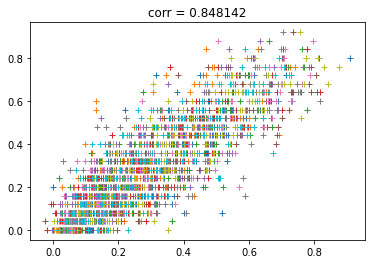

In [31]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []

for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(MaxPooling3D(pool_size=2,padding='same'))

    cnn3.add(Flatten())

    cnn3.add(Dense(64, activation='relu'))
    cnn3.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn3.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn3.fit(X_train_reshape[train], y_train[train], 
                       validation_data=(X_train_reshape[test], y_train[test]), epochs=20)
    yy_test = cnn3.predict(X_train_reshape[test])

    test_corr = np.corrcoef(yy_test[:,0],y_train[test])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_train[test],'+')
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (cnn3.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn3 Conv-Pool-Conv-Pool MaX_train_reshapePooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# a vgg like model with the trend Conv-Conv-Pool-Conv-Conv-Pool

1
Epoch 1/20
55/55 [==============================] - 14s 237ms/step - loss: 0.3987 - mse: 0.5288 - val_loss: 0.1570 - val_mse: 0.0367
Epoch 2/20
55/55 [==============================] - 13s 235ms/step - loss: 0.1684 - mse: 0.0431 - val_loss: 0.1180 - val_mse: 0.0234
Epoch 3/20
55/55 [==============================] - 13s 237ms/step - loss: 0.1189 - mse: 0.0235 - val_loss: 0.1003 - val_mse: 0.0168
Epoch 4/20
55/55 [==============================] - 13s 235ms/step - loss: 0.1016 - mse: 0.0178 - val_loss: 0.0968 - val_mse: 0.0149
Epoch 5/20
55/55 [==============================] - 13s 233ms/step - loss: 0.0900 - mse: 0.0136 - val_loss: 0.1063 - val_mse: 0.0168
Epoch 6/20
55/55 [==============================] - 13s 235ms/step - loss: 0.0875 - mse: 0.0132 - val_loss: 0.1155 - val_mse: 0.0206
Epoch 7/20
55/55 [==============================] - 13s 241ms/step - loss: 0.0922 - mse: 0.0143 - val_loss: 0.0947 - val_mse: 0.0140
Epoch 8/20
55/55 [==============================] - 13s 241ms/step 

55/55 [==============================] - 13s 235ms/step - loss: 0.1348 - mse: 0.0306 - val_loss: 0.1031 - val_mse: 0.0171
Epoch 5/20
55/55 [==============================] - 13s 235ms/step - loss: 0.1007 - mse: 0.0168 - val_loss: 0.0968 - val_mse: 0.0146
Epoch 6/20
55/55 [==============================] - 13s 234ms/step - loss: 0.0907 - mse: 0.0146 - val_loss: 0.1021 - val_mse: 0.0168
Epoch 7/20
55/55 [==============================] - 13s 238ms/step - loss: 0.0871 - mse: 0.0128 - val_loss: 0.1002 - val_mse: 0.0155
Epoch 8/20
55/55 [==============================] - 13s 234ms/step - loss: 0.0772 - mse: 0.0103 - val_loss: 0.0972 - val_mse: 0.0151
Epoch 9/20
55/55 [==============================] - 13s 234ms/step - loss: 0.0766 - mse: 0.0105 - val_loss: 0.1002 - val_mse: 0.0170
Epoch 10/20
55/55 [==============================] - 13s 238ms/step - loss: 0.0697 - mse: 0.0090 - val_loss: 0.0933 - val_mse: 0.0140
Epoch 11/20
55/55 [==============================] - 13s 237ms/step - loss: 0.0

55/55 [==============================] - 13s 245ms/step - loss: 0.0614 - mse: 0.0070 - val_loss: 0.0881 - val_mse: 0.0135
Epoch 13/20
55/55 [==============================] - 13s 245ms/step - loss: 0.0565 - mse: 0.0055 - val_loss: 0.0871 - val_mse: 0.0135
Epoch 14/20
55/55 [==============================] - 13s 244ms/step - loss: 0.0546 - mse: 0.0056 - val_loss: 0.0883 - val_mse: 0.0138
Epoch 15/20
55/55 [==============================] - 13s 242ms/step - loss: 0.0487 - mse: 0.0042 - val_loss: 0.0880 - val_mse: 0.0136
Epoch 16/20
55/55 [==============================] - 13s 244ms/step - loss: 0.0437 - mse: 0.0036 - val_loss: 0.0900 - val_mse: 0.0147
Epoch 17/20
55/55 [==============================] - 13s 243ms/step - loss: 0.0457 - mse: 0.0039 - val_loss: 0.0968 - val_mse: 0.0165
Epoch 18/20
55/55 [==============================] - 13s 244ms/step - loss: 0.0508 - mse: 0.0045 - val_loss: 0.0874 - val_mse: 0.0133
Epoch 19/20
55/55 [==============================] - 13s 242ms/step - loss

55/55 [==============================] - 13s 236ms/step - loss: 0.0442 - mse: 0.0034 - val_loss: 0.0858 - val_mse: 0.0122
mse: 1.22%
8
Epoch 1/20
55/55 [==============================] - 14s 238ms/step - loss: 0.3871 - mse: 0.4711 - val_loss: 0.1973 - val_mse: 0.0663
Epoch 2/20
55/55 [==============================] - 13s 236ms/step - loss: 0.1707 - mse: 0.0464 - val_loss: 0.1607 - val_mse: 0.0388
Epoch 3/20
55/55 [==============================] - 13s 236ms/step - loss: 0.1401 - mse: 0.0329 - val_loss: 0.1354 - val_mse: 0.0290
Epoch 4/20
55/55 [==============================] - 13s 238ms/step - loss: 0.1219 - mse: 0.0252 - val_loss: 0.1153 - val_mse: 0.0216
Epoch 5/20
55/55 [==============================] - 13s 238ms/step - loss: 0.1062 - mse: 0.0189 - val_loss: 0.1137 - val_mse: 0.0208
Epoch 6/20
55/55 [==============================] - 13s 237ms/step - loss: 0.0985 - mse: 0.0166 - val_loss: 0.1023 - val_mse: 0.0179
Epoch 7/20
55/55 [==============================] - 13s 240ms/step 

Epoch 2/20
55/55 [==============================] - 13s 236ms/step - loss: 0.1770 - mse: 0.0500 - val_loss: 0.1745 - val_mse: 0.0429
Epoch 3/20
55/55 [==============================] - 13s 239ms/step - loss: 0.1565 - mse: 0.0394 - val_loss: 0.1222 - val_mse: 0.0227
Epoch 4/20
55/55 [==============================] - 13s 237ms/step - loss: 0.1072 - mse: 0.0198 - val_loss: 0.0989 - val_mse: 0.0165
Epoch 5/20
55/55 [==============================] - 13s 238ms/step - loss: 0.0896 - mse: 0.0141 - val_loss: 0.0999 - val_mse: 0.0169
Epoch 6/20
55/55 [==============================] - 23s 421ms/step - loss: 0.0909 - mse: 0.0145 - val_loss: 0.0981 - val_mse: 0.0150
Epoch 7/20
55/55 [==============================] - 13s 237ms/step - loss: 0.0733 - mse: 0.0097 - val_loss: 0.1005 - val_mse: 0.0162
Epoch 8/20
55/55 [==============================] - 13s 234ms/step - loss: 0.0741 - mse: 0.0095 - val_loss: 0.0974 - val_mse: 0.0149
Epoch 9/20
55/55 [==============================] - 13s 235ms/step - 

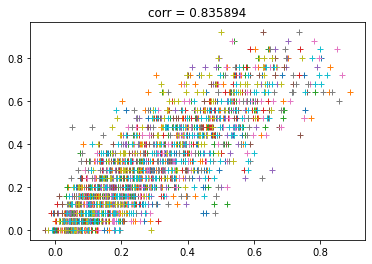

In [32]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []
i=1
for train, test in kfold.split(X_train_reshape, y_train):
    print(i)
    i=i+1
    cnn5 = Sequential()
    cnn5.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn5.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    cnn5.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn5.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn5.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn5.add(MaxPooling3D(pool_size=2,padding='same'))
    

    cnn5.add(Flatten())

    cnn5.add(Dense(512, activation='relu'))
    cnn5.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn5.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn5.fit(X_train_reshape[train], y_train[train], 
                       validation_data=(X_train_reshape[test], y_train[test]), epochs=20)
    yy_test = cnn5.predict(X_train_reshape[test])

    test_corr = np.corrcoef(yy_test[:,0],y_train[test])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_train[test],'+')
    scores = cnn5.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (cnn5.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn5 Vgg MaX_train_reshapePooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    


In [33]:
# C_P_C_P_C_P Avg Pooling

Epoch 1/20
55/55 [==============================] - 3s 40ms/step - loss: 0.2085 - mse: 0.0731 - val_loss: 0.1580 - val_mse: 0.0367
Epoch 2/20
55/55 [==============================] - 2s 38ms/step - loss: 0.1723 - mse: 0.0451 - val_loss: 0.1499 - val_mse: 0.0385
Epoch 3/20
55/55 [==============================] - 2s 38ms/step - loss: 0.1625 - mse: 0.0416 - val_loss: 0.1283 - val_mse: 0.0256
Epoch 4/20
55/55 [==============================] - 2s 37ms/step - loss: 0.1301 - mse: 0.0263 - val_loss: 0.1098 - val_mse: 0.0223
Epoch 5/20
55/55 [==============================] - 2s 38ms/step - loss: 0.1091 - mse: 0.0196 - val_loss: 0.1203 - val_mse: 0.0222
Epoch 6/20
55/55 [==============================] - 2s 37ms/step - loss: 0.1014 - mse: 0.0169 - val_loss: 0.0923 - val_mse: 0.0143
Epoch 7/20
55/55 [==============================] - 2s 38ms/step - loss: 0.0930 - mse: 0.0140 - val_loss: 0.0853 - val_mse: 0.0130
Epoch 8/20
55/55 [==============================] - 2s 37ms/step - loss: 0.0927 - m

55/55 [==============================] - 2s 37ms/step - loss: 0.0985 - mse: 0.0167 - val_loss: 0.0948 - val_mse: 0.0148
Epoch 6/20
55/55 [==============================] - 2s 37ms/step - loss: 0.0888 - mse: 0.0136 - val_loss: 0.0936 - val_mse: 0.0136
Epoch 7/20
55/55 [==============================] - 2s 37ms/step - loss: 0.0858 - mse: 0.0129 - val_loss: 0.1027 - val_mse: 0.0164
Epoch 8/20
55/55 [==============================] - 2s 38ms/step - loss: 0.0884 - mse: 0.0133 - val_loss: 0.0909 - val_mse: 0.0132
Epoch 9/20
55/55 [==============================] - 2s 37ms/step - loss: 0.0802 - mse: 0.0117 - val_loss: 0.0908 - val_mse: 0.0134
Epoch 10/20
55/55 [==============================] - 2s 38ms/step - loss: 0.0767 - mse: 0.0104 - val_loss: 0.0866 - val_mse: 0.0122
Epoch 11/20
55/55 [==============================] - 2s 37ms/step - loss: 0.0707 - mse: 0.0088 - val_loss: 0.0922 - val_mse: 0.0142
Epoch 12/20
55/55 [==============================] - 2s 37ms/step - loss: 0.0736 - mse: 0.00

Epoch 14/20
55/55 [==============================] - 2s 36ms/step - loss: 0.0632 - mse: 0.0073 - val_loss: 0.0868 - val_mse: 0.0124
Epoch 15/20
55/55 [==============================] - 2s 36ms/step - loss: 0.0612 - mse: 0.0070 - val_loss: 0.0950 - val_mse: 0.0138
Epoch 16/20
55/55 [==============================] - 2s 39ms/step - loss: 0.0652 - mse: 0.0076 - val_loss: 0.0890 - val_mse: 0.0132
Epoch 17/20
55/55 [==============================] - 2s 38ms/step - loss: 0.0583 - mse: 0.0063 - val_loss: 0.0900 - val_mse: 0.0139
Epoch 18/20
55/55 [==============================] - 2s 37ms/step - loss: 0.0521 - mse: 0.0054 - val_loss: 0.0883 - val_mse: 0.0135
Epoch 19/20
55/55 [==============================] - 2s 37ms/step - loss: 0.0482 - mse: 0.0044 - val_loss: 0.0839 - val_mse: 0.0120
Epoch 20/20
55/55 [==============================] - 2s 36ms/step - loss: 0.0481 - mse: 0.0041 - val_loss: 0.0874 - val_mse: 0.0127
mse: 1.27%
Epoch 1/20
55/55 [==============================] - 3s 39ms/step 

mse: 1.19%
Epoch 1/20
55/55 [==============================] - 3s 39ms/step - loss: 0.1923 - mse: 0.0598 - val_loss: 0.1740 - val_mse: 0.0484
Epoch 2/20
55/55 [==============================] - 2s 37ms/step - loss: 0.1693 - mse: 0.0451 - val_loss: 0.1718 - val_mse: 0.0415
Epoch 3/20
55/55 [==============================] - 2s 37ms/step - loss: 0.1493 - mse: 0.0359 - val_loss: 0.1270 - val_mse: 0.0250
Epoch 4/20
55/55 [==============================] - 2s 38ms/step - loss: 0.1187 - mse: 0.0225 - val_loss: 0.1369 - val_mse: 0.0313
Epoch 5/20
55/55 [==============================] - 2s 37ms/step - loss: 0.1130 - mse: 0.0221 - val_loss: 0.1064 - val_mse: 0.0186
Epoch 6/20
55/55 [==============================] - 2s 37ms/step - loss: 0.0923 - mse: 0.0145 - val_loss: 0.1062 - val_mse: 0.0181
Epoch 7/20
55/55 [==============================] - 2s 37ms/step - loss: 0.0871 - mse: 0.0130 - val_loss: 0.1037 - val_mse: 0.0175
Epoch 8/20
55/55 [==============================] - 2s 37ms/step - loss:

55/55 [==============================] - 2s 44ms/step - loss: 0.1029 - mse: 0.0186 - val_loss: 0.1033 - val_mse: 0.0183
Epoch 6/20
55/55 [==============================] - 2s 43ms/step - loss: 0.1035 - mse: 0.0179 - val_loss: 0.0960 - val_mse: 0.0148
Epoch 7/20
55/55 [==============================] - 2s 45ms/step - loss: 0.0894 - mse: 0.0136 - val_loss: 0.0945 - val_mse: 0.0151
Epoch 8/20
55/55 [==============================] - 2s 43ms/step - loss: 0.0911 - mse: 0.0137 - val_loss: 0.0929 - val_mse: 0.0138
Epoch 9/20
55/55 [==============================] - 2s 43ms/step - loss: 0.0881 - mse: 0.0138 - val_loss: 0.0918 - val_mse: 0.0138
Epoch 10/20
55/55 [==============================] - 2s 43ms/step - loss: 0.0849 - mse: 0.0124 - val_loss: 0.0932 - val_mse: 0.0138
Epoch 11/20
55/55 [==============================] - 2s 44ms/step - loss: 0.0810 - mse: 0.0116 - val_loss: 0.0911 - val_mse: 0.0131
Epoch 12/20
55/55 [==============================] - 2s 43ms/step - loss: 0.0740 - mse: 0.00

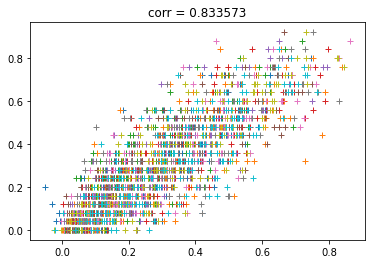

In [34]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []

for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn3.add(Flatten())

    cnn3.add(Dense(64, activation='relu'))
    cnn3.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn3.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn3.fit(X_train_reshape[train], y_train[train], 
                       validation_data=(X_train_reshape[test], y_train[test]), epochs=20)
    yy_test = cnn3.predict(X_train_reshape[test])

    test_corr = np.corrcoef(yy_test[:,0],y_train[test])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_train[test],'+')
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (cnn3.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn3 Conv-Pool-Conv-Pool AvgPooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
55/55 [==============================] - 2s 24ms/step - loss: 0.2016 - mse: 0.0648 - val_loss: 0.1525 - val_mse: 0.0395
Epoch 2/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1690 - mse: 0.0451 - val_loss: 0.1390 - val_mse: 0.0309
Epoch 3/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1378 - mse: 0.0309 - val_loss: 0.1111 - val_mse: 0.0220
Epoch 4/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1153 - mse: 0.0224 - val_loss: 0.1032 - val_mse: 0.0192
Epoch 5/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1174 - mse: 0.0231 - val_loss: 0.0975 - val_mse: 0.0156
Epoch 6/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1014 - mse: 0.0167 - val_loss: 0.1003 - val_mse: 0.0169
Epoch 7/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0918 - mse: 0.0140 - val_loss: 0.1098 - val_mse: 0.0179
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0877 - m

55/55 [==============================] - 1s 20ms/step - loss: 0.1006 - mse: 0.0167 - val_loss: 0.1104 - val_mse: 0.0187
Epoch 6/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1005 - mse: 0.0171 - val_loss: 0.0996 - val_mse: 0.0155
Epoch 7/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0884 - mse: 0.0133 - val_loss: 0.0999 - val_mse: 0.0156
Epoch 8/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0915 - mse: 0.0138 - val_loss: 0.1087 - val_mse: 0.0182
Epoch 9/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0903 - mse: 0.0140 - val_loss: 0.0904 - val_mse: 0.0134
Epoch 10/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0813 - mse: 0.0121 - val_loss: 0.0942 - val_mse: 0.0144
Epoch 11/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0777 - mse: 0.0108 - val_loss: 0.0883 - val_mse: 0.0127
Epoch 12/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0750 - mse: 0.01

Epoch 14/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0707 - mse: 0.0090 - val_loss: 0.0901 - val_mse: 0.0138
Epoch 15/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0674 - mse: 0.0086 - val_loss: 0.0936 - val_mse: 0.0159
Epoch 16/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0676 - mse: 0.0085 - val_loss: 0.0860 - val_mse: 0.0125
Epoch 17/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0600 - mse: 0.0071 - val_loss: 0.0880 - val_mse: 0.0128
Epoch 18/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0593 - mse: 0.0067 - val_loss: 0.0838 - val_mse: 0.0126
Epoch 19/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0551 - mse: 0.0057 - val_loss: 0.0899 - val_mse: 0.0135
Epoch 20/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0549 - mse: 0.0056 - val_loss: 0.0864 - val_mse: 0.0131
mse: 1.31%
Epoch 1/20
55/55 [==============================] - 2s 24ms/step 

mse: 1.16%
Epoch 1/20
55/55 [==============================] - 3s 54ms/step - loss: 0.1883 - mse: 0.0577 - val_loss: 0.1714 - val_mse: 0.0450
Epoch 2/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1661 - mse: 0.0440 - val_loss: 0.1401 - val_mse: 0.0308
Epoch 3/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1425 - mse: 0.0327 - val_loss: 0.1232 - val_mse: 0.0230
Epoch 4/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1214 - mse: 0.0232 - val_loss: 0.1176 - val_mse: 0.0223
Epoch 5/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1068 - mse: 0.0188 - val_loss: 0.1308 - val_mse: 0.0286
Epoch 6/20
55/55 [==============================] - 1s 23ms/step - loss: 0.1046 - mse: 0.0187 - val_loss: 0.1084 - val_mse: 0.0199
Epoch 7/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0905 - mse: 0.0140 - val_loss: 0.1052 - val_mse: 0.0182
Epoch 8/20
55/55 [==============================] - 1s 23ms/step - loss:

55/55 [==============================] - 1s 23ms/step - loss: 0.1097 - mse: 0.0195 - val_loss: 0.1032 - val_mse: 0.0164
Epoch 6/20
55/55 [==============================] - 1s 23ms/step - loss: 0.1023 - mse: 0.0171 - val_loss: 0.1001 - val_mse: 0.0172
Epoch 7/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0981 - mse: 0.0162 - val_loss: 0.0922 - val_mse: 0.0143
Epoch 8/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0901 - mse: 0.0136 - val_loss: 0.0886 - val_mse: 0.0129
Epoch 9/20
55/55 [==============================] - 1s 23ms/step - loss: 0.0866 - mse: 0.0126 - val_loss: 0.0995 - val_mse: 0.0168
Epoch 10/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0866 - mse: 0.0128 - val_loss: 0.0903 - val_mse: 0.0136
Epoch 11/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0805 - mse: 0.0113 - val_loss: 0.0891 - val_mse: 0.0142
Epoch 12/20
55/55 [==============================] - 1s 23ms/step - loss: 0.0742 - mse: 0.01

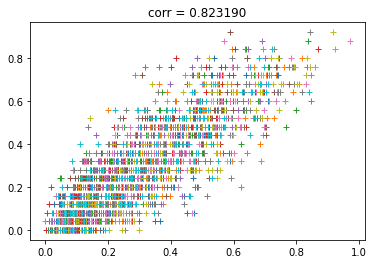

In [35]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []

for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn3.add(Flatten())

    cnn3.add(Dense(32, activation='relu'))
    cnn3.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn3.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn3.fit(X_train_reshape[train], y_train[train], 
                       validation_data=(X_train_reshape[test], y_train[test]), epochs=20)
    yy_test = cnn3.predict(X_train_reshape[test])

    test_corr = np.corrcoef(yy_test[:,0],y_train[test])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_train[test],'+')
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (cnn3.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn3 Conv-Pool-Conv-Pool AvgPooling 16,32,64 32")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
55/55 [==============================] - 6s 97ms/step - loss: 0.2445 - mse: 0.0982 - val_loss: 0.1536 - val_mse: 0.0369
Epoch 2/20
55/55 [==============================] - 5s 95ms/step - loss: 0.1778 - mse: 0.0498 - val_loss: 0.1591 - val_mse: 0.0370
Epoch 3/20
55/55 [==============================] - 5s 96ms/step - loss: 0.1771 - mse: 0.0477 - val_loss: 0.1528 - val_mse: 0.0365
Epoch 4/20
55/55 [==============================] - 5s 96ms/step - loss: 0.1709 - mse: 0.0453 - val_loss: 0.1709 - val_mse: 0.0415
Epoch 5/20
55/55 [==============================] - 5s 96ms/step - loss: 0.1531 - mse: 0.0375 - val_loss: 0.1313 - val_mse: 0.0266
Epoch 6/20
55/55 [==============================] - 5s 94ms/step - loss: 0.1351 - mse: 0.0283 - val_loss: 0.1080 - val_mse: 0.0206
Epoch 7/20
55/55 [==============================] - 5s 93ms/step - loss: 0.1151 - mse: 0.0218 - val_loss: 0.1118 - val_mse: 0.0192
Epoch 8/20
55/55 [==============================] - 10s 181ms/step - loss: 0.1028 -

55/55 [==============================] - 5s 87ms/step - loss: 0.1482 - mse: 0.0368 - val_loss: 0.1328 - val_mse: 0.0254
Epoch 6/20
55/55 [==============================] - 5s 91ms/step - loss: 0.1236 - mse: 0.0240 - val_loss: 0.1041 - val_mse: 0.0172
Epoch 7/20
55/55 [==============================] - 5s 87ms/step - loss: 0.1072 - mse: 0.0192 - val_loss: 0.1100 - val_mse: 0.0182
Epoch 8/20
55/55 [==============================] - 5s 89ms/step - loss: 0.1010 - mse: 0.0168 - val_loss: 0.1029 - val_mse: 0.0158
Epoch 9/20
55/55 [==============================] - 5s 89ms/step - loss: 0.0988 - mse: 0.0163 - val_loss: 0.0939 - val_mse: 0.0139
Epoch 10/20
55/55 [==============================] - 5s 87ms/step - loss: 0.0893 - mse: 0.0140 - val_loss: 0.0956 - val_mse: 0.0136
Epoch 11/20
55/55 [==============================] - 5s 88ms/step - loss: 0.0876 - mse: 0.0129 - val_loss: 0.0959 - val_mse: 0.0153
Epoch 12/20
55/55 [==============================] - 5s 88ms/step - loss: 0.0839 - mse: 0.01

Epoch 14/20
55/55 [==============================] - 5s 92ms/step - loss: 0.0693 - mse: 0.0086 - val_loss: 0.0890 - val_mse: 0.0130
Epoch 15/20
55/55 [==============================] - 5s 93ms/step - loss: 0.0672 - mse: 0.0082 - val_loss: 0.0912 - val_mse: 0.0130
Epoch 16/20
55/55 [==============================] - 5s 94ms/step - loss: 0.0635 - mse: 0.0075 - val_loss: 0.0903 - val_mse: 0.0131
Epoch 17/20
55/55 [==============================] - 5s 93ms/step - loss: 0.0603 - mse: 0.0069 - val_loss: 0.0899 - val_mse: 0.0131
Epoch 18/20
55/55 [==============================] - 5s 92ms/step - loss: 0.0572 - mse: 0.0062 - val_loss: 0.0908 - val_mse: 0.0143
Epoch 19/20
55/55 [==============================] - 5s 92ms/step - loss: 0.0552 - mse: 0.0058 - val_loss: 0.0905 - val_mse: 0.0131
Epoch 20/20
55/55 [==============================] - 5s 93ms/step - loss: 0.0537 - mse: 0.0054 - val_loss: 0.0901 - val_mse: 0.0134
mse: 1.34%
Epoch 1/20
55/55 [==============================] - 6s 96ms/step 

mse: 1.28%
Epoch 1/20
55/55 [==============================] - 5s 90ms/step - loss: 0.2120 - mse: 0.0769 - val_loss: 0.1759 - val_mse: 0.0496
Epoch 2/20
55/55 [==============================] - 5s 90ms/step - loss: 0.1794 - mse: 0.0490 - val_loss: 0.1726 - val_mse: 0.0469
Epoch 3/20
55/55 [==============================] - 5s 89ms/step - loss: 0.1604 - mse: 0.0406 - val_loss: 0.1419 - val_mse: 0.0301
Epoch 4/20
55/55 [==============================] - 5s 89ms/step - loss: 0.1297 - mse: 0.0279 - val_loss: 0.1483 - val_mse: 0.0362
Epoch 5/20
55/55 [==============================] - 5s 87ms/step - loss: 0.1195 - mse: 0.0240 - val_loss: 0.1178 - val_mse: 0.0221
Epoch 6/20
55/55 [==============================] - 5s 90ms/step - loss: 0.0997 - mse: 0.0165 - val_loss: 0.1148 - val_mse: 0.0194
Epoch 7/20
55/55 [==============================] - 5s 89ms/step - loss: 0.1024 - mse: 0.0175 - val_loss: 0.1052 - val_mse: 0.0188
Epoch 8/20
55/55 [==============================] - 5s 87ms/step - loss:

55/55 [==============================] - 5s 94ms/step - loss: 0.1151 - mse: 0.0217 - val_loss: 0.0967 - val_mse: 0.0157
Epoch 6/20
55/55 [==============================] - 5s 94ms/step - loss: 0.1057 - mse: 0.0184 - val_loss: 0.0966 - val_mse: 0.0162
Epoch 7/20
55/55 [==============================] - 5s 94ms/step - loss: 0.0951 - mse: 0.0156 - val_loss: 0.0971 - val_mse: 0.0145
Epoch 8/20
55/55 [==============================] - 5s 93ms/step - loss: 0.0905 - mse: 0.0140 - val_loss: 0.0934 - val_mse: 0.0143
Epoch 9/20
55/55 [==============================] - 5s 93ms/step - loss: 0.0901 - mse: 0.0139 - val_loss: 0.0891 - val_mse: 0.0136
Epoch 10/20
55/55 [==============================] - 5s 93ms/step - loss: 0.0813 - mse: 0.0112 - val_loss: 0.0875 - val_mse: 0.0131
Epoch 11/20
55/55 [==============================] - 5s 92ms/step - loss: 0.0791 - mse: 0.0109 - val_loss: 0.0977 - val_mse: 0.0161
Epoch 12/20
55/55 [==============================] - 5s 93ms/step - loss: 0.0802 - mse: 0.01

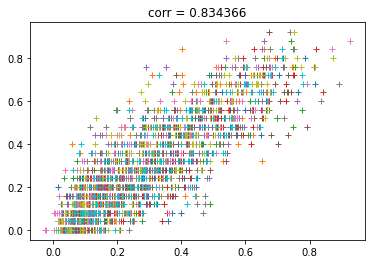

In [36]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []

for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(256, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn3.add(Flatten())

    cnn3.add(Dense(128, activation='relu'))
    cnn3.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn3.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn3.fit(X_train_reshape[train], y_train[train], 
                       validation_data=(X_train_reshape[test], y_train[test]), epochs=20)
    yy_test = cnn3.predict(X_train_reshape[test])

    test_corr = np.corrcoef(yy_test[:,0],y_train[test])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_train[test],'+')
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (cnn3.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn3 Conv-Pool-Conv-Pool AvgPooling 64,128,256 128")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
55/55 [==============================] - 3s 21ms/step - loss: 0.2037 - mse: 0.0671 - val_loss: 0.1549 - val_mse: 0.0431
Epoch 2/20
55/55 [==============================] - 1s 16ms/step - loss: 0.1751 - mse: 0.0485 - val_loss: 0.1598 - val_mse: 0.0364
Epoch 3/20
55/55 [==============================] - 1s 16ms/step - loss: 0.1505 - mse: 0.0350 - val_loss: 0.1170 - val_mse: 0.0249
Epoch 4/20
55/55 [==============================] - 1s 16ms/step - loss: 0.1304 - mse: 0.0276 - val_loss: 0.1045 - val_mse: 0.0196
Epoch 5/20
55/55 [==============================] - 1s 16ms/step - loss: 0.1080 - mse: 0.0192 - val_loss: 0.1012 - val_mse: 0.0169
Epoch 6/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1036 - mse: 0.0178 - val_loss: 0.1138 - val_mse: 0.0207
Epoch 7/20
55/55 [==============================] - 1s 16ms/step - loss: 0.1025 - mse: 0.0178 - val_loss: 0.1163 - val_mse: 0.0210
Epoch 8/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0951 - m

55/55 [==============================] - 1s 15ms/step - loss: 0.1210 - mse: 0.0234 - val_loss: 0.1093 - val_mse: 0.0194
Epoch 6/20
55/55 [==============================] - 1s 16ms/step - loss: 0.1184 - mse: 0.0234 - val_loss: 0.1069 - val_mse: 0.0195
Epoch 7/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1053 - mse: 0.0186 - val_loss: 0.1077 - val_mse: 0.0188
Epoch 8/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0989 - mse: 0.0158 - val_loss: 0.1057 - val_mse: 0.0168
Epoch 9/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0998 - mse: 0.0168 - val_loss: 0.1198 - val_mse: 0.0204
Epoch 10/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1002 - mse: 0.0162 - val_loss: 0.0973 - val_mse: 0.0143
Epoch 11/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0912 - mse: 0.0139 - val_loss: 0.0924 - val_mse: 0.0136
Epoch 12/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0844 - mse: 0.01

Epoch 14/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0712 - mse: 0.0092 - val_loss: 0.1040 - val_mse: 0.0189
Epoch 15/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0741 - mse: 0.0100 - val_loss: 0.0955 - val_mse: 0.0147
Epoch 16/20
55/55 [==============================] - 1s 17ms/step - loss: 0.0690 - mse: 0.0084 - val_loss: 0.0894 - val_mse: 0.0135
Epoch 17/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0658 - mse: 0.0079 - val_loss: 0.0950 - val_mse: 0.0143
Epoch 18/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0684 - mse: 0.0085 - val_loss: 0.1056 - val_mse: 0.0195
Epoch 19/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0660 - mse: 0.0082 - val_loss: 0.0879 - val_mse: 0.0135
Epoch 20/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0583 - mse: 0.0065 - val_loss: 0.0954 - val_mse: 0.0154
mse: 1.54%
Epoch 1/20
55/55 [==============================] - 2s 20ms/step 

mse: 1.16%
Epoch 1/20
55/55 [==============================] - 2s 18ms/step - loss: 0.1932 - mse: 0.0597 - val_loss: 0.1795 - val_mse: 0.0539
Epoch 2/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1719 - mse: 0.0457 - val_loss: 0.1568 - val_mse: 0.0384
Epoch 3/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1594 - mse: 0.0407 - val_loss: 0.1320 - val_mse: 0.0268
Epoch 4/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1231 - mse: 0.0246 - val_loss: 0.1154 - val_mse: 0.0218
Epoch 5/20
55/55 [==============================] - 1s 16ms/step - loss: 0.1125 - mse: 0.0209 - val_loss: 0.1117 - val_mse: 0.0203
Epoch 6/20
55/55 [==============================] - 1s 16ms/step - loss: 0.1059 - mse: 0.0191 - val_loss: 0.1172 - val_mse: 0.0221
Epoch 7/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0999 - mse: 0.0173 - val_loss: 0.1357 - val_mse: 0.0307
Epoch 8/20
55/55 [==============================] - 1s 16ms/step - loss:

55/55 [==============================] - 1s 15ms/step - loss: 0.1192 - mse: 0.0232 - val_loss: 0.1166 - val_mse: 0.0237
Epoch 6/20
55/55 [==============================] - 1s 15ms/step - loss: 0.1081 - mse: 0.0194 - val_loss: 0.1041 - val_mse: 0.0184
Epoch 7/20
55/55 [==============================] - 1s 16ms/step - loss: 0.1006 - mse: 0.0168 - val_loss: 0.1151 - val_mse: 0.0224
Epoch 8/20
55/55 [==============================] - 1s 16ms/step - loss: 0.1031 - mse: 0.0178 - val_loss: 0.0950 - val_mse: 0.0152
Epoch 9/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0905 - mse: 0.0137 - val_loss: 0.0974 - val_mse: 0.0158
Epoch 10/20
55/55 [==============================] - 1s 16ms/step - loss: 0.0882 - mse: 0.0137 - val_loss: 0.0943 - val_mse: 0.0149
Epoch 11/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0801 - mse: 0.0111 - val_loss: 0.0969 - val_mse: 0.0149
Epoch 12/20
55/55 [==============================] - 1s 15ms/step - loss: 0.0835 - mse: 0.01

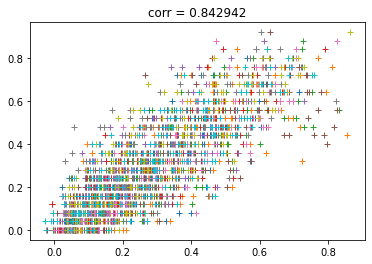

In [37]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []

for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn3.add(Flatten())

    cnn3.add(Dense(16, activation='relu'))
    cnn3.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn3.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn3.fit(X_train_reshape[train], y_train[train], 
                       validation_data=(X_train_reshape[test], y_train[test]), epochs=20)
    yy_test = cnn3.predict(X_train_reshape[test])

    test_corr = np.corrcoef(yy_test[:,0],y_train[test])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_train[test],'+')
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (cnn3.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn3 Conv-Pool-Conv-Pool AvgPooling 8,16,32 16")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
55/55 [==============================] - 4s 27ms/step - loss: 0.1992 - mse: 0.0631 - val_loss: 0.1533 - val_mse: 0.0361
Epoch 2/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1691 - mse: 0.0449 - val_loss: 0.1548 - val_mse: 0.0430
Epoch 3/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1680 - mse: 0.0438 - val_loss: 0.1628 - val_mse: 0.0392
Epoch 4/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1348 - mse: 0.0290 - val_loss: 0.1146 - val_mse: 0.0209
Epoch 5/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1144 - mse: 0.0208 - val_loss: 0.1023 - val_mse: 0.0172
Epoch 6/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1025 - mse: 0.0178 - val_loss: 0.0963 - val_mse: 0.0149
Epoch 7/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0939 - mse: 0.0149 - val_loss: 0.1019 - val_mse: 0.0166
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0905 - m

55/55 [==============================] - 1s 20ms/step - loss: 0.1050 - mse: 0.0185 - val_loss: 0.0988 - val_mse: 0.0146
Epoch 6/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0955 - mse: 0.0154 - val_loss: 0.1043 - val_mse: 0.0163
Epoch 7/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0955 - mse: 0.0156 - val_loss: 0.1039 - val_mse: 0.0158
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0863 - mse: 0.0126 - val_loss: 0.0973 - val_mse: 0.0153
Epoch 9/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0851 - mse: 0.0123 - val_loss: 0.0949 - val_mse: 0.0135
Epoch 10/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0778 - mse: 0.0106 - val_loss: 0.0906 - val_mse: 0.0124
Epoch 11/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0778 - mse: 0.0105 - val_loss: 0.0911 - val_mse: 0.0125
Epoch 12/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0741 - mse: 0.00

Epoch 14/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0667 - mse: 0.0083 - val_loss: 0.0903 - val_mse: 0.0136
Epoch 15/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0624 - mse: 0.0073 - val_loss: 0.0984 - val_mse: 0.0166
Epoch 16/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0647 - mse: 0.0077 - val_loss: 0.0877 - val_mse: 0.0133
Epoch 17/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0634 - mse: 0.0076 - val_loss: 0.0920 - val_mse: 0.0138
Epoch 18/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0616 - mse: 0.0070 - val_loss: 0.0990 - val_mse: 0.0180
Epoch 19/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0630 - mse: 0.0077 - val_loss: 0.0917 - val_mse: 0.0136
Epoch 20/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0589 - mse: 0.0063 - val_loss: 0.0879 - val_mse: 0.0123
mse: 1.23%
Epoch 1/20
55/55 [==============================] - 2s 25ms/step 

mse: 1.12%
Epoch 1/20
55/55 [==============================] - 2s 23ms/step - loss: 0.1988 - mse: 0.0648 - val_loss: 0.1768 - val_mse: 0.0452
Epoch 2/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1751 - mse: 0.0468 - val_loss: 0.1737 - val_mse: 0.0481
Epoch 3/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1644 - mse: 0.0414 - val_loss: 0.1526 - val_mse: 0.0369
Epoch 4/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1425 - mse: 0.0322 - val_loss: 0.1171 - val_mse: 0.0218
Epoch 5/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1195 - mse: 0.0228 - val_loss: 0.1130 - val_mse: 0.0207
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1095 - mse: 0.0198 - val_loss: 0.1117 - val_mse: 0.0189
Epoch 7/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0984 - mse: 0.0165 - val_loss: 0.1089 - val_mse: 0.0189
Epoch 8/20
55/55 [==============================] - 1s 20ms/step - loss:

55/55 [==============================] - 1s 21ms/step - loss: 0.1152 - mse: 0.0216 - val_loss: 0.1135 - val_mse: 0.0222
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1072 - mse: 0.0191 - val_loss: 0.0975 - val_mse: 0.0155
Epoch 7/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0984 - mse: 0.0166 - val_loss: 0.0925 - val_mse: 0.0142
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0907 - mse: 0.0139 - val_loss: 0.0976 - val_mse: 0.0147
Epoch 9/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0891 - mse: 0.0134 - val_loss: 0.0958 - val_mse: 0.0159
Epoch 10/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0821 - mse: 0.0117 - val_loss: 0.0910 - val_mse: 0.0139
Epoch 11/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0793 - mse: 0.0115 - val_loss: 0.0895 - val_mse: 0.0137
Epoch 12/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0715 - mse: 0.00

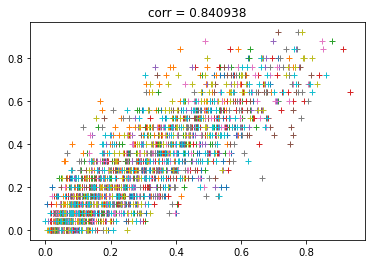

In [38]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []

for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn3.add(Flatten())

    cnn3.add(Dense(32, activation='relu'))
    cnn3.add(Dense(64, activation='relu'))
    cnn3.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn3.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn3.fit(X_train_reshape[train], y_train[train], 
                       validation_data=(X_train_reshape[test], y_train[test]), epochs=20)
    yy_test = cnn3.predict(X_train_reshape[test])

    test_corr = np.corrcoef(yy_test[:,0],y_train[test])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_train[test],'+')
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (cnn3.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn3 Conv-Pool-Conv-Pool AvgPooling 16,32,64 32,64")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
55/55 [==============================] - 2s 25ms/step - loss: 0.1929 - mse: 0.0590 - val_loss: 0.1540 - val_mse: 0.0359
Epoch 2/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1813 - mse: 0.0487 - val_loss: 0.1453 - val_mse: 0.0362
Epoch 3/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1513 - mse: 0.0368 - val_loss: 0.1580 - val_mse: 0.0365
Epoch 4/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1350 - mse: 0.0304 - val_loss: 0.1133 - val_mse: 0.0206
Epoch 5/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1095 - mse: 0.0196 - val_loss: 0.0989 - val_mse: 0.0174
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1004 - mse: 0.0172 - val_loss: 0.0944 - val_mse: 0.0160
Epoch 7/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0997 - mse: 0.0168 - val_loss: 0.0904 - val_mse: 0.0139
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0969 - m

55/55 [==============================] - 1s 22ms/step - loss: 0.1249 - mse: 0.0259 - val_loss: 0.1103 - val_mse: 0.0187
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1030 - mse: 0.0181 - val_loss: 0.1025 - val_mse: 0.0175
Epoch 7/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0926 - mse: 0.0146 - val_loss: 0.0987 - val_mse: 0.0153
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0930 - mse: 0.0143 - val_loss: 0.0980 - val_mse: 0.0156
Epoch 9/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0896 - mse: 0.0139 - val_loss: 0.1056 - val_mse: 0.0170
Epoch 10/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0899 - mse: 0.0135 - val_loss: 0.0952 - val_mse: 0.0143
Epoch 11/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0808 - mse: 0.0116 - val_loss: 0.0938 - val_mse: 0.0136
Epoch 12/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0768 - mse: 0.01

Epoch 14/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0739 - mse: 0.0095 - val_loss: 0.0911 - val_mse: 0.0128
Epoch 15/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0696 - mse: 0.0089 - val_loss: 0.0873 - val_mse: 0.0133
Epoch 16/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0688 - mse: 0.0088 - val_loss: 0.0914 - val_mse: 0.0135
Epoch 17/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0663 - mse: 0.0079 - val_loss: 0.0855 - val_mse: 0.0124
Epoch 18/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0594 - mse: 0.0065 - val_loss: 0.0878 - val_mse: 0.0128
Epoch 19/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0603 - mse: 0.0069 - val_loss: 0.0856 - val_mse: 0.0121
Epoch 20/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0591 - mse: 0.0066 - val_loss: 0.0880 - val_mse: 0.0129
mse: 1.29%
Epoch 1/20
55/55 [==============================] - 2s 26ms/step 

mse: 1.16%
Epoch 1/20
55/55 [==============================] - 2s 31ms/step - loss: 0.2108 - mse: 0.0708 - val_loss: 0.1749 - val_mse: 0.0496
Epoch 2/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1703 - mse: 0.0449 - val_loss: 0.1627 - val_mse: 0.0407
Epoch 3/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1554 - mse: 0.0379 - val_loss: 0.1410 - val_mse: 0.0335
Epoch 4/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1230 - mse: 0.0245 - val_loss: 0.1292 - val_mse: 0.0269
Epoch 5/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1108 - mse: 0.0205 - val_loss: 0.1235 - val_mse: 0.0241
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0991 - mse: 0.0167 - val_loss: 0.1222 - val_mse: 0.0245
Epoch 7/20
55/55 [==============================] - 1s 20ms/step - loss: 0.1003 - mse: 0.0168 - val_loss: 0.1164 - val_mse: 0.0208
Epoch 8/20
55/55 [==============================] - 1s 22ms/step - loss:

55/55 [==============================] - 1s 21ms/step - loss: 0.1155 - mse: 0.0219 - val_loss: 0.1128 - val_mse: 0.0215
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1071 - mse: 0.0191 - val_loss: 0.1019 - val_mse: 0.0178
Epoch 7/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0971 - mse: 0.0156 - val_loss: 0.1020 - val_mse: 0.0172
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0925 - mse: 0.0155 - val_loss: 0.1035 - val_mse: 0.0182
Epoch 9/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0857 - mse: 0.0129 - val_loss: 0.0941 - val_mse: 0.0140
Epoch 10/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0831 - mse: 0.0116 - val_loss: 0.0921 - val_mse: 0.0141
Epoch 11/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0782 - mse: 0.0107 - val_loss: 0.1071 - val_mse: 0.0193
Epoch 12/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0806 - mse: 0.01

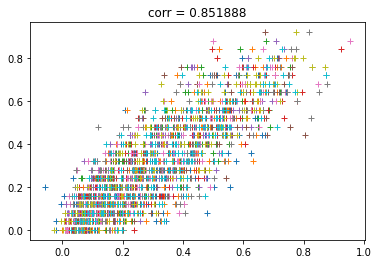

In [39]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []

for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn3.add(Flatten())

    cnn3.add(Dense(32, activation='relu'))
    
    cnn3.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.01)
    cnn3.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn3.fit(X_train_reshape[train], y_train[train], 
                       validation_data=(X_train_reshape[test], y_train[test]), epochs=20)
    yy_test = cnn3.predict(X_train_reshape[test])

    test_corr = np.corrcoef(yy_test[:,0],y_train[test])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_train[test],'+')
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (cnn3.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn3 Conv-Pool-Conv-Pool AvgPooling 16,32,64 32 lr 0.01")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
55/55 [==============================] - 2s 24ms/step - loss: 0.1957 - mse: 0.0620 - val_loss: 0.1532 - val_mse: 0.0412
Epoch 2/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1743 - mse: 0.0484 - val_loss: 0.1814 - val_mse: 0.0447
Epoch 3/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1613 - mse: 0.0414 - val_loss: 0.1260 - val_mse: 0.0253
Epoch 4/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1322 - mse: 0.0281 - val_loss: 0.1120 - val_mse: 0.0206
Epoch 5/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1204 - mse: 0.0236 - val_loss: 0.1048 - val_mse: 0.0169
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1089 - mse: 0.0201 - val_loss: 0.1027 - val_mse: 0.0172
Epoch 7/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0953 - mse: 0.0158 - val_loss: 0.1096 - val_mse: 0.0190
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0999 - m

55/55 [==============================] - 1s 21ms/step - loss: 0.1021 - mse: 0.0175 - val_loss: 0.0918 - val_mse: 0.0136
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0894 - mse: 0.0135 - val_loss: 0.1025 - val_mse: 0.0162
Epoch 7/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0921 - mse: 0.0145 - val_loss: 0.0910 - val_mse: 0.0130
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0819 - mse: 0.0119 - val_loss: 0.0925 - val_mse: 0.0139
Epoch 9/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0815 - mse: 0.0119 - val_loss: 0.0946 - val_mse: 0.0135
Epoch 10/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0806 - mse: 0.0115 - val_loss: 0.0870 - val_mse: 0.0120
Epoch 11/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0775 - mse: 0.0106 - val_loss: 0.0917 - val_mse: 0.0135
Epoch 12/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0759 - mse: 0.01

Epoch 14/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0692 - mse: 0.0090 - val_loss: 0.0922 - val_mse: 0.0146
Epoch 15/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0672 - mse: 0.0083 - val_loss: 0.0859 - val_mse: 0.0126
Epoch 16/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0643 - mse: 0.0076 - val_loss: 0.0867 - val_mse: 0.0132
Epoch 17/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0663 - mse: 0.0077 - val_loss: 0.0855 - val_mse: 0.0126
Epoch 18/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0596 - mse: 0.0068 - val_loss: 0.0860 - val_mse: 0.0124
Epoch 19/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0554 - mse: 0.0059 - val_loss: 0.0915 - val_mse: 0.0146
Epoch 20/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0522 - mse: 0.0051 - val_loss: 0.0877 - val_mse: 0.0134
mse: 1.34%
Epoch 1/20
55/55 [==============================] - 2s 24ms/step 

mse: 1.24%
Epoch 1/20
55/55 [==============================] - 2s 25ms/step - loss: 0.1909 - mse: 0.0568 - val_loss: 0.1691 - val_mse: 0.0449
Epoch 2/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1654 - mse: 0.0427 - val_loss: 0.1423 - val_mse: 0.0329
Epoch 3/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1372 - mse: 0.0309 - val_loss: 0.1336 - val_mse: 0.0311
Epoch 4/20
55/55 [==============================] - 1s 21ms/step - loss: 0.1106 - mse: 0.0206 - val_loss: 0.1194 - val_mse: 0.0245
Epoch 5/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1126 - mse: 0.0217 - val_loss: 0.1219 - val_mse: 0.0251
Epoch 6/20
55/55 [==============================] - 1s 22ms/step - loss: 0.1007 - mse: 0.0172 - val_loss: 0.1092 - val_mse: 0.0202
Epoch 7/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0902 - mse: 0.0136 - val_loss: 0.1067 - val_mse: 0.0189
Epoch 8/20
55/55 [==============================] - 1s 22ms/step - loss:

55/55 [==============================] - 1s 20ms/step - loss: 0.1023 - mse: 0.0179 - val_loss: 0.0976 - val_mse: 0.0158
Epoch 6/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0985 - mse: 0.0161 - val_loss: 0.0906 - val_mse: 0.0135
Epoch 7/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0890 - mse: 0.0135 - val_loss: 0.0910 - val_mse: 0.0142
Epoch 8/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0894 - mse: 0.0137 - val_loss: 0.0937 - val_mse: 0.0151
Epoch 9/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0831 - mse: 0.0122 - val_loss: 0.0855 - val_mse: 0.0124
Epoch 10/20
55/55 [==============================] - 1s 22ms/step - loss: 0.0801 - mse: 0.0112 - val_loss: 0.0877 - val_mse: 0.0128
Epoch 11/20
55/55 [==============================] - 1s 20ms/step - loss: 0.0753 - mse: 0.0103 - val_loss: 0.0862 - val_mse: 0.0124
Epoch 12/20
55/55 [==============================] - 1s 21ms/step - loss: 0.0697 - mse: 0.00

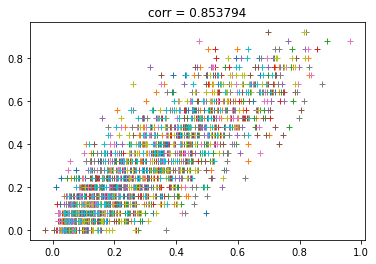

In [40]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []

for train, test in kfold.split(X_train_reshape, y_train):
    cnn3 = Sequential()
    cnn3.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',
                    input_shape=(X_train_reshape[train].shape[1],
                                 X_train_reshape[train].shape[2],X_train_reshape[train].shape[3],1)),)
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn3.add(Flatten())

    cnn3.add(Dense(32, activation='relu'))
    
    cnn3.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.1)
    cnn3.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = cnn3.fit(X_train_reshape[train], y_train[train], 
                       validation_data=(X_train_reshape[test], y_train[test]), epochs=20)
    yy_test = cnn3.predict(X_train_reshape[test])

    test_corr = np.corrcoef(yy_test[:,0],y_train[test])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_train[test],'+')
    scores = cnn3.evaluate(X_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (cnn3.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn3 Conv-Pool-Conv-Pool AvgPooling 16,32,64 32 lr 0.1")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))